# Notebook to process Kaggle's Titanic dataset

This notebook uses the dataset from Kaggle's Titanic Comptetition to train a logistic regression and provides results with the test dataset
https://www.kaggle.com/c/titanic

author: drublackberry (github)

## Configuration
User configuration parameters

In [1]:
train_size = 80 # % of the training set used for training
N_MonteCarlo = 50 # number of runs for the monte-carlo analysis

## Data pre-processing and exploratory data analysis
Gather the train dataset, convert feature to numerical values and plot the values in stacked histograms to get a feeling of the importance of the features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image, display
    
# Load into CSV
myRawDf = pd.read_csv('train.csv', index_col=0)

## Feature exploration
This chapter will explore the weight of the features wrt survival rate and will explore the possibilities of 

### Features on the name
The name itself can contain some features of interest, if we explore it closely we can see that the pattern of ', 'and '.' allows us to retrieve the title and the surname.

In [3]:
# Inspect the names to see if something can be done
myRawDf['Name'].head(10)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Let's create two extra columns with the title and the surname to be used as features.

In [4]:
import re

def getTitle (aName):
    '''Finds the title in the name'''
    myPosStart = aName.find(',')
    myPosEnd = aName.find('.')
    return re.sub('[^A-Za-z0-9]+', '', aName[myPosStart:myPosEnd])
def getSurname (aName):
    '''Finds the title in the name'''
    myPos = aName.find(',')
    return re.sub('[^A-Za-z0-9]+', '', aName[:myPos])

myInDf = myRawDf.copy()
myInDf['Title'] = [getTitle(x) for x in myInDf['Name']]
myInDf['Surname'] = [getSurname(x) for x in myInDf['Name']]

# Get a sample
myInDf.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen


In order to be able to plot and perform regressions (if needed) one can assign a number to each string for each feature.

In [5]:
def assignNumericalType (aSeries):
    '''Assigns a numerical type to string values'''
    val = aSeries.unique()
    myDict = {val[x]:x for x in range(len(val))}
    myDict[np.nan] = np.nan # Ensure nan stays nan
    aOut = [myDict[x] for x in aSeries]
    return aOut

# Convert strings to numerical type
for myCol in myInDf.columns:
    if type(myInDf[myCol].dropna().iloc[0])==str:
        myInDf[myCol] = assignNumericalType(myInDf[myCol])
        
# Get a sample
myInDf.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
1,0,3,0,0,22.0,1,0,0,7.2500,NaN,0.0,0,0
2,1,1,1,1,38.0,1,0,1,71.2833,1.0,1.0,1,1
3,1,3,2,1,26.0,0,0,2,7.9250,NaN,0.0,2,2
4,1,1,3,1,35.0,1,0,3,53.1000,2.0,0.0,1,3
5,0,3,4,0,35.0,0,0,4,8.0500,NaN,0.0,0,4


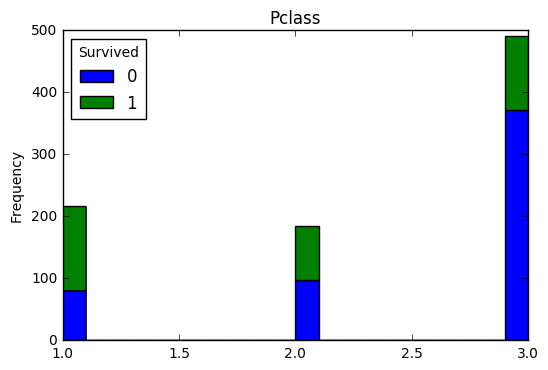

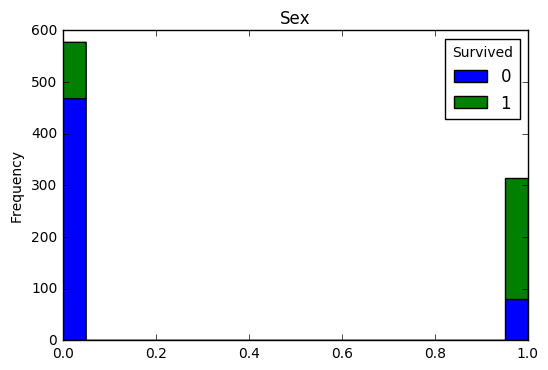

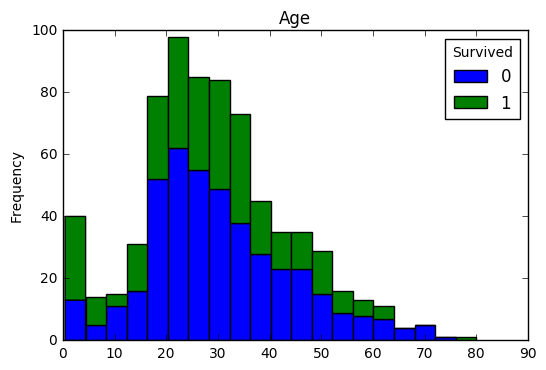

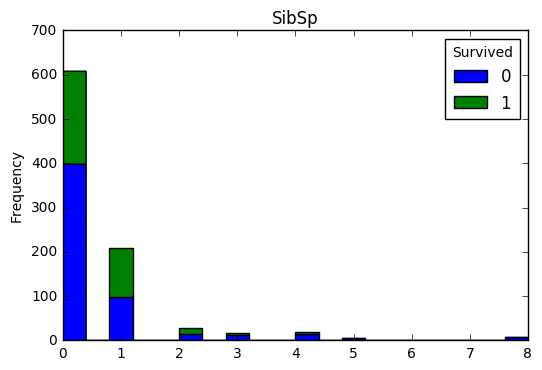

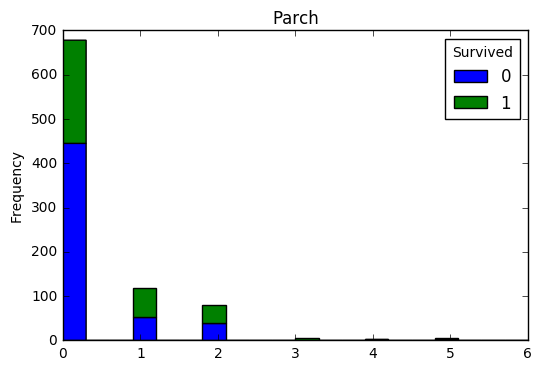

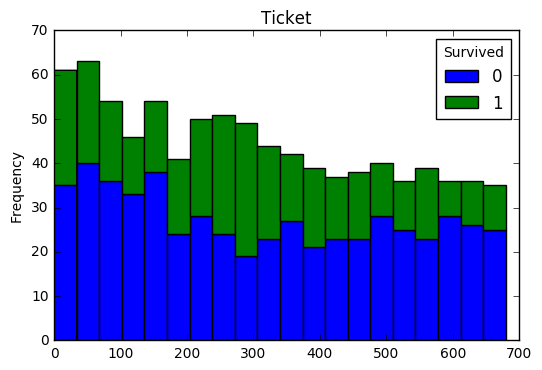

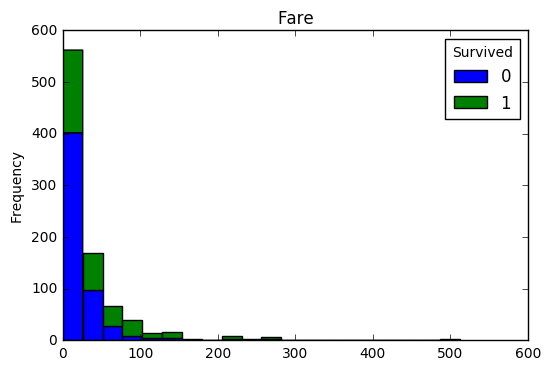

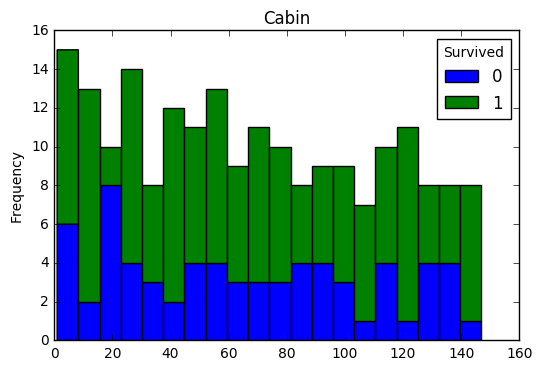

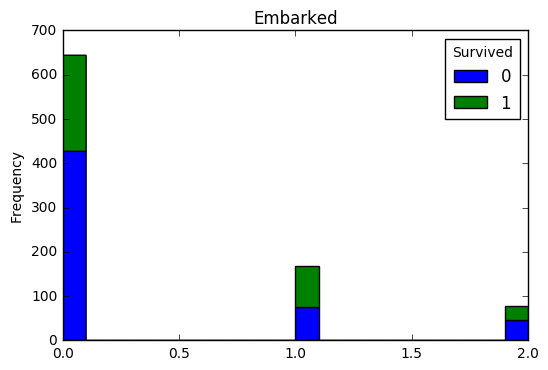

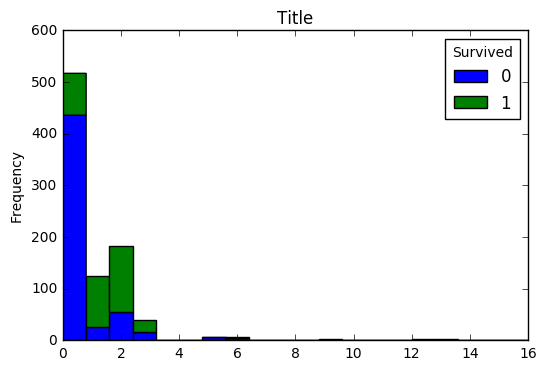

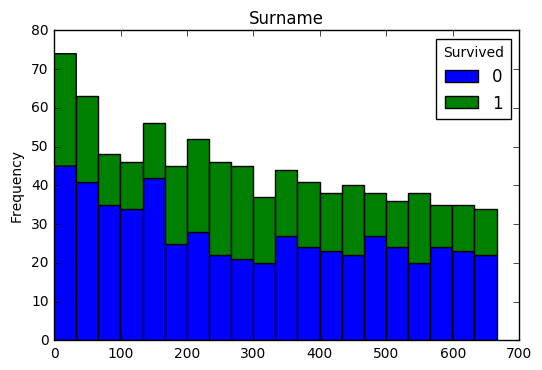

In [6]:
# Exploratory data analysis
for myFeature in myInDf.columns:
    if myFeature != 'Survived' and (len(myInDf[myFeature]) > len(myInDf[myFeature].unique())):
        myInDf.pivot(columns='Survived', values=myFeature).plot(kind='hist', stacked=True, bins=20)
        plt.title(myFeature)
        plt.show()

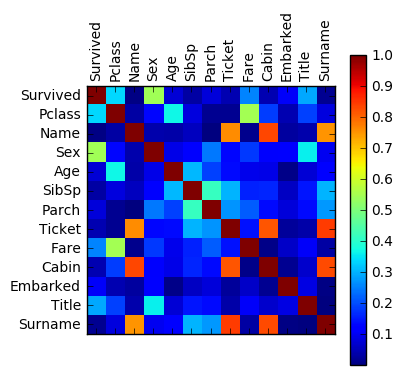

In [7]:
# Do a correlation plot
cax = plt.matshow(myInDf.corr().abs())
plt.colorbar(cax)
plt.xticks(range(len(myInDf.columns)), myInDf.columns, rotation='vertical')
plt.yticks(range(len(myInDf.columns)), myInDf.columns, rotation='horizontal')
plt.show()

## Conclusions of the exploratory data analysis

* Passenger on the age 20-40 are more likely to die.
* Babies and infants are more likely to survive.
* Most passenger where in the range 20-40 with children (i.e. families).
* Older people is more likely to survive
* Lower fares are more likely to die
* People with more than 3 siblings is likely to die
* Travelling with no siblings meant a higher change of survival
* People not related to children are more likely to die
* There is a clear dependence on passenger class
* Males are more likely to die
* There is a certain dependence on the cabin, port and ticket
* There is high correlation of hte survival with sex, pclass and . Weaker correlations with parch and embarked.
* Title is a strong feature for survival

## Missing data
A part of the dataset is missing, how many missing values do we have in the training set per feature?

In [8]:
myMissingDf = pd.DataFrame(columns=['Missing', 'Total'], index=myInDf.columns)
myMissingDf['Missing'] = myInDf.isnull().sum()
myMissingDf['Total'] = myInDf.replace(np.nan,'0').count()
myMissingDf

,Missing,Total
Survived,0,891
Pclass,0,891
Name,0,891
Sex,0,891
Age,177,891
SibSp,0,891
Parch,0,891
Ticket,0,891
Fare,0,891
Cabin,687,891


Given the results one can conclude that
* The age is missing for a number of passengers but it is still a usable feature given the amount of it that is missing
* The cabin is missing for large part of the dataset, if used as feature it will have little weight
* Two passenger are missing the port where they embarked, the feature should be still usable

The age feature is specially interesting given the high correlation with the survival

### Predicting age
Age is a key feature that is missing in a considerable part of the dataset, however, the age can be infered from other features. The predicted age can be used to feed the decision tree.

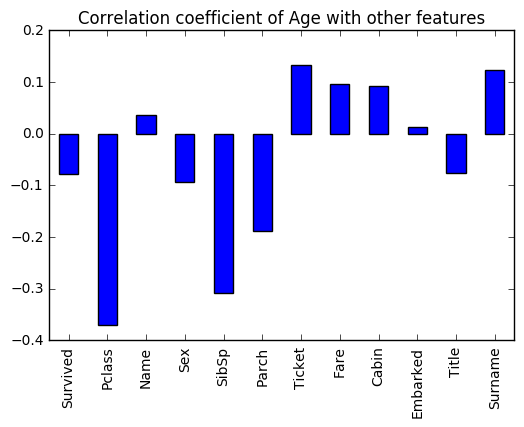

In [9]:
myInDf.corr()[[x for x in myInDf.columns if x != 'Age']].loc['Age'].plot(kind='bar')
plt.title('Correlation coefficient of Age with other features')
plt.show()

In [10]:
# Predict the age with a linear regression
from sklearn import linear_model
from sklearn.preprocessing import normalize

myAgeDf = myInDf[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Age', 'Title', 'Surname']]
myLR = linear_model.LinearRegression()
# Prepare the training set for the regression
myXage = myAgeDf.dropna()[[x for x in myAgeDf.columns if x != 'Age']]
myXage = pd.DataFrame(normalize(myXage, axis=0), columns=myXage.columns, index=myXage.index)
myLR.fit (myXage, myAgeDf.dropna()['Age'])
# Predict and fill the initial dataframe
myXagePred = myAgeDf.loc[myAgeDf.isnull()['Age']][[x for x in myAgeDf.columns if x != 'Age']]
myInDf.loc[myXagePred.index, 'Age'] = myLR.predict(normalize(myXagePred, axis=0))

# Check the results (there should be no nan for the age)
myInDf.loc[myXagePred.index].head(5)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
6,0,3,5,0,9.298766,0,0,5,8.4583,NaN,2.0,0,5
18,1,2,17,0,8.060071,0,0,17,13.0000,NaN,0.0,0,17
20,1,3,19,1,-6.556581,0,0,19,7.2250,NaN,1.0,1,19
27,0,3,26,0,9.381120,0,0,25,7.2250,NaN,1.0,0,25
29,1,3,28,1,-8.658415,0,0,27,7.8792,NaN,2.0,2,27


### Missing embarked values
There are two values with nan for the embarked. Embarked is a feature that holds a certain correlation with the survival rate. It should be better to keep it.
Let's work on the raw data to see the alphanumerical values

In [11]:
myRawDf[myRawDf['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Both of them where at Cabin B28, on which port did the passengers at these cabin also board? Also it is OK to assume that the tickets where sold in order.

In [12]:
myRawDf[myRawDf['Ticket'].map(lambda x: '1135' in x or '1136' in x)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S
357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S
378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
524,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C


One can see that a number of passenger with similar fare price, cabin on the same section and ticket number close enough to the missing ones embarked in 'C'. Let's assume that's their port of origin

In [13]:
# Assign a numerical value
myInDf.loc[myInDf['Embarked'].isnull(), 'Embarked'] = myInDf.loc[55]['Embarked']
# Check
myInDf.loc[[62,830]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname
PassengerId,,,,,,,,,,,,,
62,1,1,61,1,38.0,0,0,60,80.0,13.0,1.0,2,59
830,1,1,829,1,62.0,0,0,60,80.0,13.0,1.0,1,629


# Classification using decision trees

In [14]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score
    
def splitDataset (aDf, aFrac):
    '''Splits a Df in a training and a validation dataset randomly'''
    aTrainDf = aDf.sample(frac=aFrac/100.)
    myValInd = [ind for ind in aDf.index if ind not in aTrainDf.index]
    aValDf = aDf.loc[myValInd]
    # Create X and Y datasets
    aXtrain = aTrainDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYtrain = aTrainDf['Survived']
    aXval = aValDf[[x for x in aTrainDf.columns if x!='Survived']]
    aYval = aValDf['Survived']
    return aXtrain, aYtrain, aXval, aYval

def assessPerformance (aX, aY, aClf):
    '''Prints the performance of a certain machine learning algorithm'''
    myYpred = aClf.predict(aX)
    aPrecision = precision_score(aY, myYpred)
    aRecall = recall_score(aY, myYpred)
    aF1score = f1_score(aY, myYpred)
    return aPrecision, aRecall, aF1score

def trainPredictAndAnalyze (aDf, aDepth=None, draw=False):
    # Build a decision tree classifier
    myXtrain, myYtrain, myXval, myYval = splitDataset (aDf, train_size)
    myClf = tree.DecisionTreeClassifier(max_depth=aDepth)
    myClf = myClf.fit(myXtrain, myYtrain)
    aTrainPrecision, aTrainRecall, aTrainF1 = assessPerformance(myXtrain, myYtrain, myClf)
    aValPrecision, aValRecall, aValF1 = assessPerformance(myXval, myYval, myClf)
    if draw:
        # Draw the decision tree
        myDotData = tree.export_graphviz(myClf, feature_names=myXtrain.columns, out_file='tree.dot' )
        (myGraph,) = pydot.graph_from_dot_file('tree.dot')
        myPlt = Image(myGraph.create_png())
        myGraph.write_png('tree.png')
        display(myPlt)
    return aTrainPrecision, aTrainRecall, aTrainF1, aValPrecision, aValRecall, aValF1
   
def runMonteCarlo (aDf, aDepth=None):
    myPerfDf = pd.DataFrame(columns=['Train Precision', 'Train Recall', 'Train F1', 'Val Precision', 'Val Recall', 'Val F1'])
    for i in range(N_MonteCarlo):
        myPerfDf.loc[i] = trainPredictAndAnalyze(aDf, aDepth)
    return myPerfDf

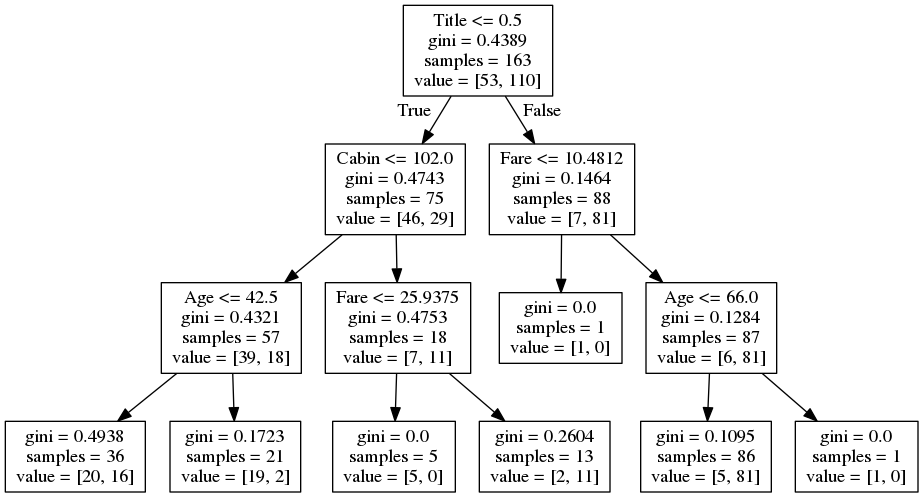

In [15]:
# Calling and drawing a precision tree with max_depth
# Note that this call removes all the nan (large part of the dataset) and just displays a decision tree for illustration
foo = trainPredictAndAnalyze(myInDf.dropna(), aDepth=3, draw=True)

Try out different cleaning methods for the data, since the data has many missing values

In [16]:
# Removing all the features with nan values on it
from sklearn.preprocessing import Imputer
myImp = Imputer(missing_values='NaN', strategy='mean', axis=1)
myImp.fit(myInDf)
myNewDf = pd.DataFrame(myImp.transform(myInDf), columns=myInDf.columns)
myStats = runMonteCarlo(myNewDf).describe() # capture output of dataframe for further usage
myStats

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.709104,0.721025,0.713694
std,0.0,0.0,0.0,0.053317,0.054992,0.044694
min,1.0,1.0,1.0,0.580645,0.589041,0.615385
25%,1.0,1.0,1.0,0.666667,0.685340,0.681818
50%,1.0,1.0,1.0,0.717584,0.724161,0.713732
75%,1.0,1.0,1.0,0.752717,0.757874,0.747431
max,1.0,1.0,1.0,0.807692,0.833333,0.802920


In [17]:
# Do not use features which have any value missing
myCompleteFeatures = [x for x in myMissingDf.index if myMissingDf['Missing'].loc[x]==0]
runMonteCarlo(myInDf[myCompleteFeatures]).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.705136,0.694781,0.697644
std,0.0,0.0,0.0,0.055410,0.065534,0.045259
min,1.0,1.0,1.0,0.597403,0.573770,0.608696
25%,1.0,1.0,1.0,0.666667,0.643908,0.662990
50%,1.0,1.0,1.0,0.704022,0.678235,0.699187
75%,1.0,1.0,1.0,0.746567,0.747283,0.726557
max,1.0,1.0,1.0,0.846154,0.818182,0.792453


In [18]:
# Do not use the cabin feature and imput with the mean
myColToUse = [x for x in myInDf.columns if x != 'Cabin']
myImp.fit(myInDf[myColToUse])
myNewDf = pd.DataFrame(myImp.transform(myInDf[myColToUse]), columns=myColToUse)
runMonteCarlo(myNewDf).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.708887,0.717754,0.711880
std,0.0,0.0,0.0,0.054824,0.050279,0.041410
min,1.0,1.0,1.0,0.589041,0.600000,0.614173
25%,1.0,1.0,1.0,0.671429,0.687500,0.689777
50%,1.0,1.0,1.0,0.706275,0.723607,0.712121
75%,1.0,1.0,1.0,0.735907,0.757942,0.736865
max,1.0,1.0,1.0,0.861538,0.800000,0.791946


In [19]:
runMonteCarlo(myInDf.replace(np.nan, -1)).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.701581,0.714768,0.705461
std,0.0,0.0,0.0,0.062221,0.057592,0.041536
min,1.0,1.0,1.0,0.569620,0.571429,0.633333
25%,1.0,1.0,1.0,0.658862,0.688002,0.676692
50%,1.0,1.0,1.0,0.700061,0.719155,0.700795
75%,1.0,1.0,1.0,0.743350,0.745763,0.735757
max,1.0,1.0,1.0,0.861538,0.870968,0.787097


In [20]:
runMonteCarlo(myInDf[[x for x in myInDf.columns if x != 'Cabin']].dropna()).describe()

,Train Precision,Train Recall,Train F1,Val Precision,Val Recall,Val F1
count,50.0,50.0,50.0,50.000000,50.000000,50.000000
mean,1.0,1.0,1.0,0.703634,0.713168,0.707039
std,0.0,0.0,0.0,0.057007,0.063762,0.051507
min,1.0,1.0,1.0,0.567164,0.544118,0.573643
25%,1.0,1.0,1.0,0.669118,0.673137,0.688160
50%,1.0,1.0,1.0,0.702914,0.719375,0.712650
75%,1.0,1.0,1.0,0.739726,0.756757,0.741220
max,1.0,1.0,1.0,0.820896,0.845070,0.805369


## Preventing overtitting

Here a number of draws will be done on the validation set to come up with a level of depth that minimizes the validation error

In [21]:
# Create a MultiIndex dataframe to store the stats of all the different runs
myMaxDepthArray = np.array(range(len(myInDf.columns)))+1
myIndex = pd.MultiIndex.from_product([myMaxDepthArray, myStats.index])
myDf = pd.DataFrame(index=myIndex, columns=myStats.columns)
for myDepth in myMaxDepthArray:
    myDf.loc[myDepth,:].iloc[:] = runMonteCarlo(myInDf.replace(np.nan,-1), aDepth=myDepth).describe().iloc[:]